<a href="https://colab.research.google.com/github/jalilabdelhamid/openmc/blob/main/OpenMC_Installation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# **Installation of OpenMC ** 

In [ ]:
!git clone --recurse-submodules https://github.com/openmc-dev/openmc.git
%cd openmc
!mkdir build && cd build
%cd build/
!cmake ..
!make -j 4
!make install
%cd ..
!pip install .
%cd ..
!wget https://anl.box.com/shared/static/9igk353zpy8fn9ttvtrqgzvw1vtejoz6.xz
!tar -xvf 9igk353zpy8fn9ttvtrqgzvw1vtejoz6.xz
%env OPENMC_CROSS_SECTIONS=/content/endfb-vii.1-hdf5/cross_sections.xml


Cloning into 'openmc'...
remote: Enumerating objects: 106675, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 106675 (delta 12), reused 23 (delta 12), pack-reused 106649
Receiving objects: 100% (106675/106675), 64.40 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (79125/79125), done.
Submodule 'vendor/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'vendor/fmt'
Submodule 'vendor/gsl-lite' (https://github.com/martinmoene/gsl-lite.git) registered for path 'vendor/gsl-lite'
Submodule 'vendor/pugixml' (https://github.com/zeux/pugixml.git) registered for path 'vendor/pugixml'
Submodule 'vendor/xtensor' (https://github.com/xtensor-stack/xtensor.git) registered for path 'vendor/xtensor'
Submodule 'vendor/xtl' (https://github.com/xtensor-stack/xtl.git) registered for path 'vendor/xtl'
Cloning into '/content/openmc/vendor/fmt'...
remote: Enumerating objects: 30942, done.        
remote: Counting objects: 100% (134/

Example from openmc github:

 https://github.com/openmc-dev/openmc/blob/develop/examples/pincell/build_xml.py





In [ ]:

from math import log10

import numpy as np
import openmc

###############################################################################
# Create materials for the problem

uo2 = openmc.Material(name='UO2 fuel at 2.4% wt enrichment')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014  , 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001  , 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

# Collect the materials together and export to XML
materials = openmc.Materials([uo2, helium, zircaloy, borated_water])
materials.export_to_xml()

###############################################################################
# Define problem geometry

# Create cylindrical surfaces
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')

# Create a region represented as the inside of a rectangular prism
pitch = 1.25984
box = openmc.rectangular_prism(pitch, pitch, boundary_type='reflective')

# Create cells, mapping materials to regions
fuel = openmc.Cell(fill=uo2, region=-fuel_or)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or)
water = openmc.Cell(fill=borated_water, region=+clad_or & box)

# Create a geometry and export to XML
geometry = openmc.Geometry([fuel, gap, clad, water])
geometry.export_to_xml()

###############################################################################
# Define problem settings

# Indicate how many particles to run
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
lower_left = (-pitch/2, -pitch/2, -1)
upper_right = (pitch/2, pitch/2, 1)
uniform_dist = openmc.stats.Box(lower_left, upper_right, only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

# For source convergence checks, add a mesh that can be used to calculate the
# Shannon entropy
entropy_mesh = openmc.RegularMesh()
entropy_mesh.lower_left = (-fuel_or.r, -fuel_or.r)
entropy_mesh.upper_right = (fuel_or.r, fuel_or.r)
entropy_mesh.dimension = (10, 10)
settings.entropy_mesh = entropy_mesh
settings.export_to_xml()

###############################################################################
# Define tallies

# Create a mesh that will be used for tallying
mesh = openmc.RegularMesh()
mesh.dimension = (100, 100)
mesh.lower_left = (-pitch/2, -pitch/2)
mesh.upper_right = (pitch/2, pitch/2)

# Create a mesh filter that can be used in a tally
mesh_filter = openmc.MeshFilter(mesh)

# Now use the mesh filter in a tally and indicate what scores are desired
mesh_tally = openmc.Tally(name="Mesh tally")
mesh_tally.filters = [mesh_filter]
mesh_tally.scores = ['flux', 'fission', 'nu-fission']

# Let's also create a tally to get the flux energy spectrum. We start by
# creating an energy filter
e_min, e_max = 1e-5, 20.0e6
groups = 500
energies = np.logspace(log10(e_min), log10(e_max), groups + 1)
energy_filter = openmc.EnergyFilter(energies)

spectrum_tally = openmc.Tally(name="Flux spectrum")
spectrum_tally.filters = [energy_filter]
spectrum_tally.scores = ['flux']

# Instantiate a Tallies collection and export to XML
tallies = openmc.Tallies([mesh_tally, spectrum_tally])
tallies.export_to_xml()


     
openmc.run()
     


     


     


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################


# **Spectrum Plot **




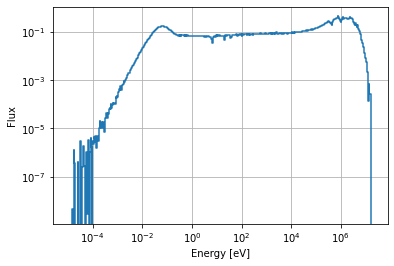

In [ ]:
import matplotlib.pyplot as plt
import openmc


# Get results from statepoint
with openmc.StatePoint('statepoint.100.h5') as sp:
    t = sp.get_tally(name="Flux spectrum")

    # Get the energies from the energy filter
    energy_filter = t.filters[0]
    energies = energy_filter.bins[:, 0]

    # Get the flux values
    mean = t.get_values(value='mean').ravel()
    uncertainty = t.get_values(value='std_dev').ravel()

# Plot flux spectrum
fix, ax = plt.subplots()
ax.loglog(energies, mean, drawstyle='steps-post')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux')
ax.grid(True, which='both')
plt.show()